In [1]:
import numpy as np
import networkx as nx

from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
edges = np.genfromtxt('../../data/Flickr_sampled_edges/edges_sampled_map_2K.csv', delimiter=',', dtype='int64')
y = np.genfromtxt('../../data/Flickr_sampled_edges/community_membership_2K.csv', delimiter=',', dtype='int')
y = [t[1] for t in y]

In [3]:
def shortest_path(G, s):
    S = []
    P = {}
    for v in G:
        P[v] = []
    sigma = dict.fromkeys(G, 0.0)    # sigma[v]=0 for v in G
    D = {}
    sigma[s] = 1.0
    D[s] = 0
    Q = [s]
    while Q:   # use BFS to find shortest paths
        v = Q.pop(0)
        S.append(v)
        Dv = D[v]
        sigmav = sigma[v]
        for w in G[v]:
            if w not in D:
                Q.append(w)
                D[w] = Dv + 1
            if D[w] == Dv + 1:   # this is a shortest path, count paths
                sigma[w] += sigmav
                P[w].append(v)  # predecessors
    return S, P, sigma

def accumulate(betweenness, S, P, sigma, s):
    delta = dict.fromkeys(S, 0)
    while S:
        w = S.pop()
        coeff = (1.0 + delta[w]) / sigma[w]
        for v in P[w]:
            c = sigma[v] * coeff
            if (v, w) not in betweenness:
                betweenness[(w, v)] += c
            else:
                betweenness[(v, w)] += c
            delta[v] += c
        if w != s:
            betweenness[w] += delta[w]
    return betweenness

def rescale(betweenness, n):
    if n <= 1:
        scale = None  # no normalization b=0 for all nodes
    else:
        scale = 1.0 / (n * (n - 1))
    if scale is not None:
        for v in betweenness:
            betweenness[v] *= scale
    return betweenness

In [4]:
def betweeness(G):
    betweenness = dict.fromkeys(G, 0.0)  # b[v]=0 for v in G
    # b[e]=0 for e in G.edges()
    betweenness.update(dict.fromkeys(G.edges(), 0.0))
    nodes = G
    
    for s in nodes:
        # single source shortest paths use BFS
        S, P, sigma = shortest_path(G, s)
        # accumulation
        betweenness = accumulate(betweenness, S, P, sigma, s)
    # rescaling
    for n in G:  # remove nodes to only return edges
        del betweenness[n]
    betweenness = rescale(betweenness, len(G))
    return betweenness

In [5]:
def modularity(_G, G):    
    B = nx.modularity_matrix(_G)
    
    c = {}
    for i, x in enumerate(sorted(nx.connected_components(G), key = len, reverse=True)):
        for n in x:
            c[n] = i
    
    _sum = 0
    n = len(_G)
    m = _G.number_of_edges()
    for i in range(n):
        for j in range(n):
            d = 1 if c[i] == c[j] else 0
            _sum += d * B.item((i, j))
            
    return _sum / (2 * m)

In [6]:
def GN(G):
    modularities = []
    communities = []
    _iter = 0
    
    _G = deepcopy(G)
    
    while G.number_of_edges() > 1:
        _iter += 1
        
        comp = nx.number_connected_components(G)
        n_comp = comp
        
#         while n_comp <= comp:
        _betweeness = betweeness(G)
        e = max(_betweeness, key=_betweeness.get)
        G.remove_edge(*e)
        n_comp = nx.number_connected_components(G)
        
#         if G.number_of_edges() > 1:
        m = modularity(_G, G)
        modularities.append(m)
        c = nx.number_connected_components(G)
        communities.append(c)
        
        if _iter % 100 == 0:
            print("Iter %d: Modularity %f, Communities %d" % (_iter, m, c))
            
    return modularities, communities

In [7]:
G = nx.Graph()
G.add_edges_from(edges)
mods, coms = GN(G)


Iter 100: Modularity 0.400607, Communities 57
Iter 200: Modularity 0.382468, Communities 79
Iter 300: Modularity 0.365249, Communities 97
Iter 400: Modularity 0.345819, Communities 115
Iter 500: Modularity 0.326760, Communities 130
Iter 600: Modularity 0.311353, Communities 141
Iter 700: Modularity 0.290269, Communities 153
Iter 800: Modularity 0.269153, Communities 167
Iter 900: Modularity 0.253968, Communities 176
Iter 1000: Modularity 0.232608, Communities 185
Iter 1100: Modularity 0.215984, Communities 194
Iter 1200: Modularity 0.201442, Communities 202
Iter 1300: Modularity 0.184309, Communities 211
Iter 1400: Modularity 0.166505, Communities 222
Iter 1500: Modularity 0.142844, Communities 231
Iter 1600: Modularity 0.122764, Communities 241
Iter 1700: Modularity 0.101128, Communities 252
Iter 1800: Modularity 0.077788, Communities 261
Iter 1900: Modularity 0.049987, Communities 274
Iter 2000: Modularity 0.026066, Communities 285


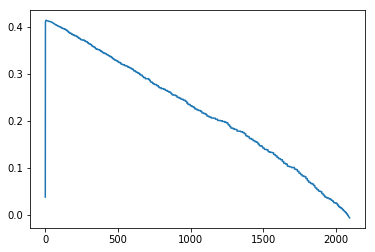

In [8]:
plt.plot(mods)